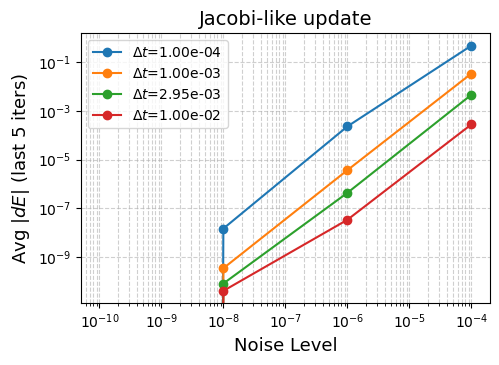

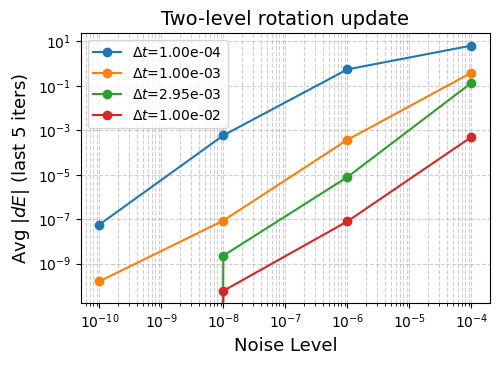

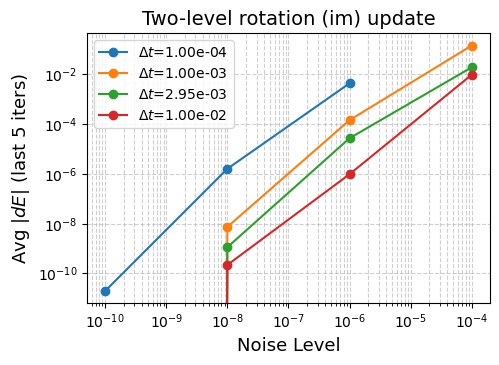

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict

# --- User options ---
sys_str = "h2o"  # molecule string in filename
update_types = {'jl': 'Jacobi-like', 'tlr': 'Two-level rotation', 'tlrim': 'Two-level rotation (im)'}
plot_update_types = ['jl', 'tlr', 'tlrim']  # which update types to plot
dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")
# You may need to adjust the update_pattern if your update_type string is different

# --- Gather all files ---
all_files = glob.glob(f"ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize data: {update_type: {dt: {noise: [avg_last5_dE, ...]}}} ---
data = {ut: defaultdict(lambda: defaultdict(list)) for ut in plot_update_types}

for fname in all_files:
    # Parse dt, noise, update_type
    dt_m = dt_pattern.search(fname)
    noise_m = noise_pattern.search(fname)
    update_m = update_pattern.search(fname)
    if not (dt_m and noise_m and update_m):
        continue
    dt = float(dt_m.group(1))
    noise = float(noise_m.group(1))
    update_type = update_m.group(1)
    if update_type not in plot_update_types:
        continue

    # Read last 5 dE values (3rd column)
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    if len(lines) < 5:
        continue
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    dE = np.abs(arr[-5:, 2])
    avg_last5 = np.mean(dE)
    data[update_type][dt][noise].append(avg_last5)

# --- Plotting ---
for ut in plot_update_types:
    plt.figure(figsize=(5.1, 3.75))
    for dt in sorted(data[ut].keys()):
        noises = sorted(data[ut][dt].keys())
        avg_dEs = [np.mean(data[ut][dt][n]) for n in noises]
        plt.plot(noises, avg_dEs, marker='o', label=f"$\Delta t$={dt:.2e}")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Noise Level", fontsize=13)
    plt.ylabel("Avg $|dE|$ (last 5 iters)", fontsize=13)
    plt.title(f"{update_types[ut]} update", fontsize=14)
    plt.grid(True, which='both', ls='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

Saved figure as figures/noise_vs_avgdE_h2o_color_dt.pdf


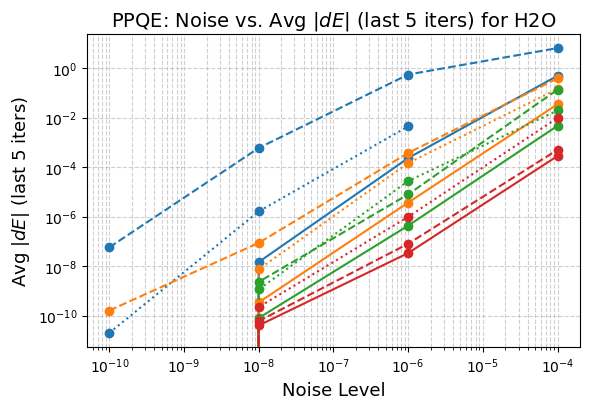

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"  # molecule string in filename

# Color palette for dt values (expand as needed)
color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
plot_update_types = ['jl', 'tlr', 'tlrim']
dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")

# --- Gather all files ---
all_files = glob.glob(f"ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize data: {dt: {update_type: {noise: [avg_last5_dE, ...]}}} ---
data = defaultdict(lambda: {ut: defaultdict(list) for ut in plot_update_types})

for fname in all_files:
    # Parse dt, noise, update_type
    dt_m = dt_pattern.search(fname)
    noise_m = noise_pattern.search(fname)
    update_m = update_pattern.search(fname)
    if not (dt_m and noise_m and update_m):
        continue
    dt = float(dt_m.group(1))
    noise = float(noise_m.group(1))
    update_type = update_m.group(1)
    if update_type not in plot_update_types:
        continue

    # Read last 5 dE values (3rd column)
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    if len(lines) < 5:
        continue
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    dE = np.abs(arr[-5:, 2])
    avg_last5 = np.mean(dE)
    data[dt][update_type][noise].append(avg_last5)

# --- Assign a color to each dt ---
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

# --- Plot all update types on the same graph, color by dt, linestyle by update type ---
plt.figure(figsize=(6, 4.2))

for i, dt in enumerate(dt_vals):
    color = dt_to_color[dt]
    for ut in plot_update_types:
        noises = sorted(data[dt][ut].keys())
        if not noises:
            continue
        avg_dEs = [np.mean(data[dt][ut][n]) for n in noises]
        label = f"$\Delta t$={dt:.2e}, {update_types[ut]['label']}"
        plt.plot(
            noises, avg_dEs, marker='o',
            linestyle=update_types[ut]['linestyle'],
            color=color,
            label=label
        )

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Noise Level", fontsize=13)
plt.ylabel("Avg $|dE|$ (last 5 iters)", fontsize=13)
plt.title(f"PPQE: Noise vs. Avg $|dE|$ (last 5 iters) for {sys_str.upper()}", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
# plt.legend(fontsize=9, loc='best')
plt.tight_layout()

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/noise_vs_avgdE_{sys_str}_color_dt.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

Saved figure as figures/dt_vs_avgdE_h2o_color_noise.pdf


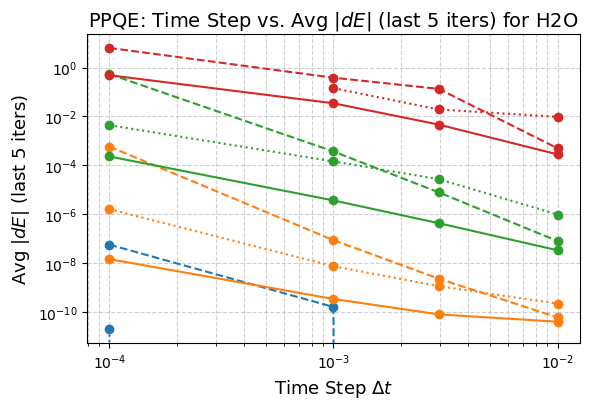

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"  # molecule string in filename

# Color palette for noise values (expand as needed)
color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
plot_update_types = ['jl', 'tlr', 'tlrim']
dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")

# --- Gather all files ---
all_files = glob.glob(f"ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize data: {noise: {update_type: {dt: [avg_last5_dE, ...]}}} ---
data = defaultdict(lambda: {ut: defaultdict(list) for ut in plot_update_types})

for fname in all_files:
    # Parse dt, noise, update_type
    dt_m = dt_pattern.search(fname)
    noise_m = noise_pattern.search(fname)
    update_m = update_pattern.search(fname)
    if not (dt_m and noise_m and update_m):
        continue
    dt = float(dt_m.group(1))
    noise = float(noise_m.group(1))
    update_type = update_m.group(1)
    if update_type not in plot_update_types:
        continue

    # Read last 5 dE values (3rd column)
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    if len(lines) < 5:
        continue
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    dE = np.abs(arr[-5:, 2])
    avg_last5 = np.mean(dE)
    data[noise][update_type][dt].append(avg_last5)

# --- Assign a color to each noise value ---
noise_vals = sorted(data.keys())
noise_to_color = {noise: color_list[i % len(color_list)] for i, noise in enumerate(noise_vals)}

# --- Plot all update types on the same graph, color by noise, linestyle by update type ---
plt.figure(figsize=(6, 4.2))

for i, noise in enumerate(noise_vals):
    color = noise_to_color[noise]
    for ut in plot_update_types:
        dts = sorted(data[noise][ut].keys())
        if not dts:
            continue
        avg_dEs = [np.mean(data[noise][ut][dt]) for dt in dts]
        label = f"Noise={noise:.1e}, {update_types[ut]['label']}"
        plt.plot(
            dts, avg_dEs, marker='o',
            linestyle=update_types[ut]['linestyle'],
            color=color,
            label=label
        )

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Time Step $\Delta t$", fontsize=13)
plt.ylabel("Avg $|dE|$ (last 5 iters)", fontsize=13)
plt.title(f"PPQE: Time Step vs. Avg $|dE|$ (last 5 iters) for {sys_str.upper()}", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
# plt.legend(fontsize=9, loc='best')
plt.tight_layout()

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/dt_vs_avgdE_{sys_str}_color_noise.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

Saved figure as figures/shots_vs_avgdE_h2o_color_dt.pdf


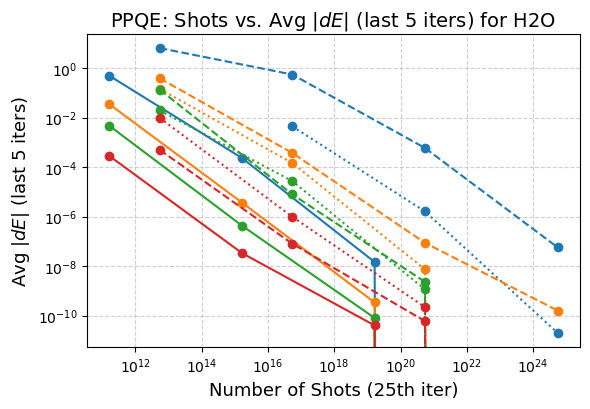

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"  # molecule string in filename

# Color palette for dt values (expand as needed)
color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
plot_update_types = ['jl', 'tlr', 'tlrim']
dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")

# --- Gather all files ---
all_files = glob.glob(f"ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize data: {dt: {update_type: {nshots: [avg_last5_dE, ...]}}} ---
data = defaultdict(lambda: {ut: defaultdict(list) for ut in plot_update_types})

for fname in all_files:
    # Parse dt, update_type
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    if not (dt_m and update_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    if update_type not in plot_update_types:
        continue

    # Read last 5 dE values (3rd column) and nshots (last column)
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    if len(lines) < 25:
        continue
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    dE = np.abs(arr[-5:, 2])
    avg_last5 = np.mean(dE)
    nshots = arr[24, -1]  # 25th iteration, last column

    data[dt][update_type][nshots].append(avg_last5)

# --- Assign a color to each dt ---
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

# --- Plot all update types on the same graph, color by dt, linestyle by update type ---
plt.figure(figsize=(6, 4.2))

for i, dt in enumerate(dt_vals):
    color = dt_to_color[dt]
    for ut in plot_update_types:
        nshots_list = sorted(data[dt][ut].keys())
        if not nshots_list:
            continue
        avg_dEs = [np.mean(data[dt][ut][n]) for n in nshots_list]
        label = f"$\Delta t$={dt:.2e}, {update_types[ut]['label']}"
        plt.plot(
            nshots_list, avg_dEs, marker='o',
            linestyle=update_types[ut]['linestyle'],
            color=color,
            label=label
        )

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Shots (25th iter)", fontsize=13)
plt.ylabel("Avg $|dE|$ (last 5 iters)", fontsize=13)
plt.title(f"PPQE: Shots vs. Avg $|dE|$ (last 5 iters) for {sys_str.upper()}", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
# plt.legend(fontsize=9, loc='best')
plt.tight_layout()

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/shots_vs_avgdE_{sys_str}_color_dt.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()